Data set taken from here: https://www.kaggle.com/prasunroy/natural-images

# Preperations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

Set up the GPUs if we can use them.

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    print("Configuring", device)
    tf.config.experimental.set_memory_growth(device, True)

Configuring PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Import our training and test images

In [3]:
IMAGE_SIZE = (100, 100)

train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    #rotation_range=25,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #brightness_range=(0.9, 1.1),
    #horizontal_flip=True,
    #vertical_flip=True,
    validation_split=0.2,
)

training_images = train_image_generator.flow_from_directory(
    directory="natural_images",
    #batch_size=32,
    shuffle=True,
    target_size=IMAGE_SIZE,
    subset="training"
)

test_images = train_image_generator.flow_from_directory(
    directory="natural_images",
    #batch_size=32,
    shuffle=True,
    target_size=IMAGE_SIZE,
    subset="validation"
)

NUM_CLASSES = training_images.num_classes

Found 4847 images belonging to 7 classes.
Found 1209 images belonging to 7 classes.


Show some images from the loaded data set

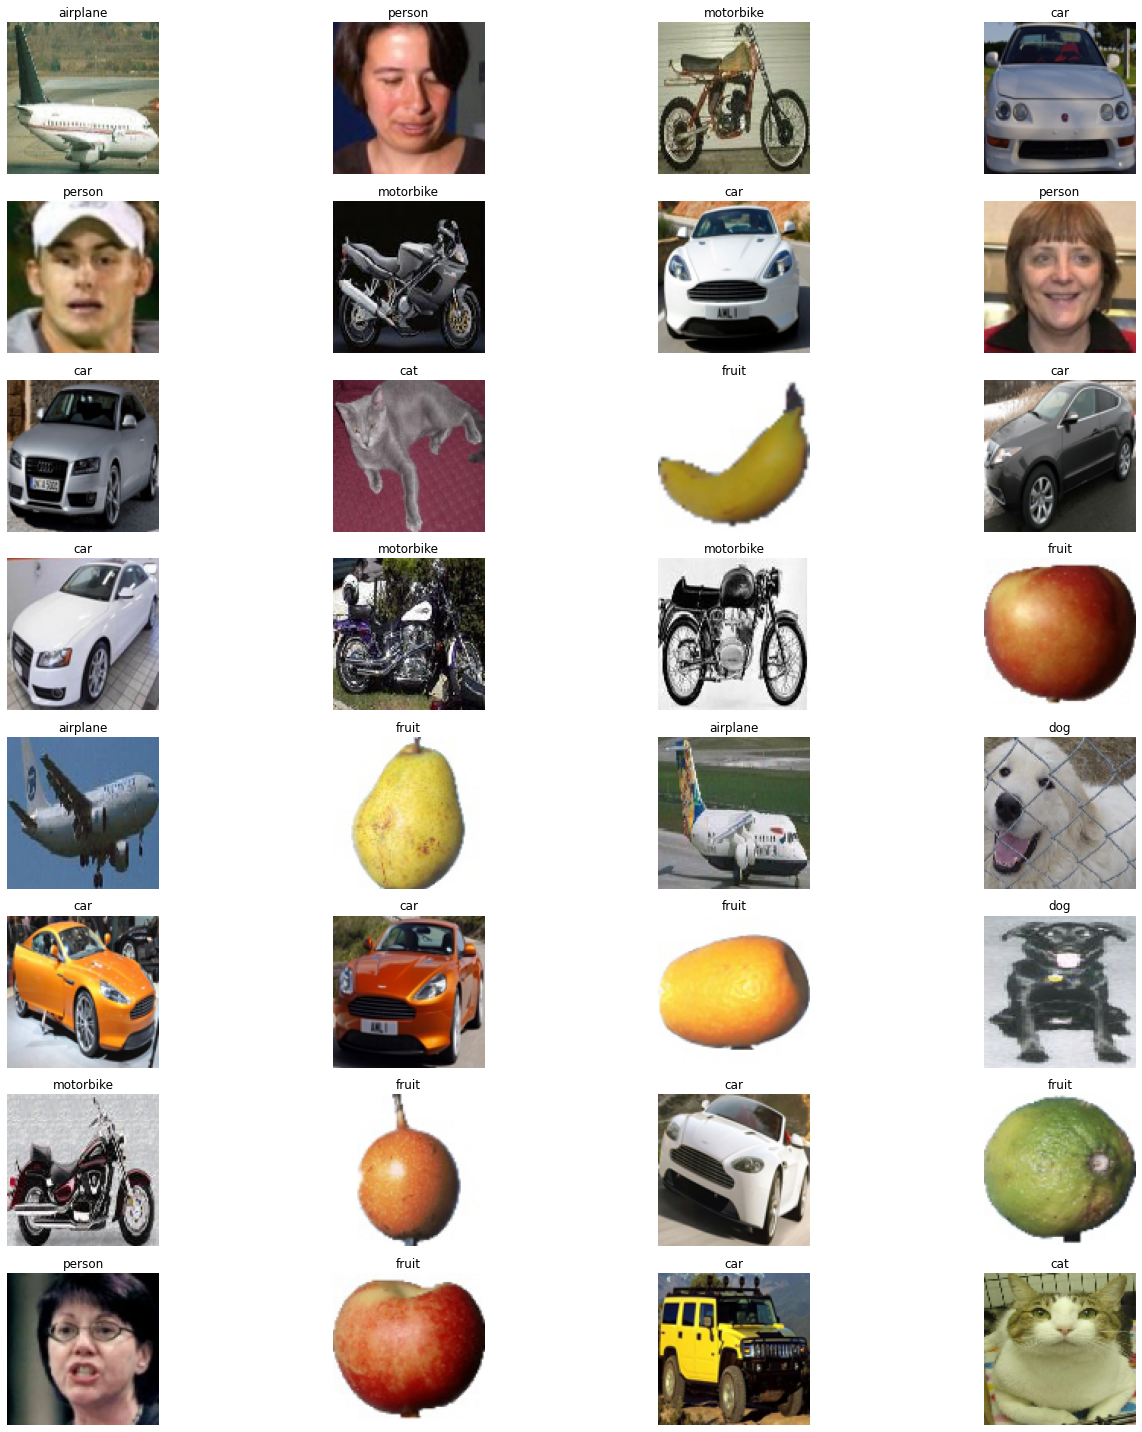

In [4]:
sample_training_images, labels = next(training_images)
class_label = {v:k for k,v in training_images.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# Neural Network

Create a basic CNN

In [5]:
# This neural net is garbage:
model = Sequential([
    #layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMAGE_SIZE + (3,)),
    layers.Conv2D(16, 2, padding='same', activation='relu', input_shape=IMAGE_SIZE + (3,)),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(150, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# model = Sequential([
#     layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=IMAGE_SIZE + (3,)),
#     layers.MaxPool2D(pool_size=(2, 2)),
#     layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
#     layers.MaxPool2D(pool_size=(2, 2)),
#     layers.Dropout(rate=0.25),
#     layers.Flatten(),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(rate=0.5),
#     layers.Dense(NUM_CLASSES, activation='softmax'),
# ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       3

Then train the model with the training images.

In [6]:
EPOCHS = 10
STEPS = 30

In [7]:
model.compile(
    optimizer='adam',
    #optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
    #metrics=['accuracy'],
)

history = model.fit(
    training_images,
    validation_data=test_images,
    validation_steps=STEPS,
    epochs=EPOCHS,
    steps_per_epoch=STEPS,
)

Epoch 1/10
30/30 [==============================] - 2s 60ms/step - loss: 1.6804 - categorical_accuracy: 0.3302 - val_loss: 1.2927 - val_categorical_accuracy: 0.5052
Epoch 2/10
30/30 [==============================] - 2s 50ms/step - loss: 0.9498 - categorical_accuracy: 0.6385 - val_loss: 0.7423 - val_categorical_accuracy: 0.7229
Epoch 3/10
30/30 [==============================] - 1s 50ms/step - loss: 0.6787 - categorical_accuracy: 0.7594 - val_loss: 0.6067 - val_categorical_accuracy: 0.7750
Epoch 4/10
30/30 [==============================] - 2s 51ms/step - loss: 0.5848 - categorical_accuracy: 0.7740 - val_loss: 0.6725 - val_categorical_accuracy: 0.7583
Epoch 5/10
30/30 [==============================] - 2s 51ms/step - loss: 0.5149 - categorical_accuracy: 0.8070 - val_loss: 0.4799 - val_categorical_accuracy: 0.8302
Epoch 6/10
30/30 [==============================] - 2s 53ms/step - loss: 0.4271 - categorical_accuracy: 0.8354 - val_loss: 0.4639 - val_categorical_accuracy: 0.8167
Epoch 7/10

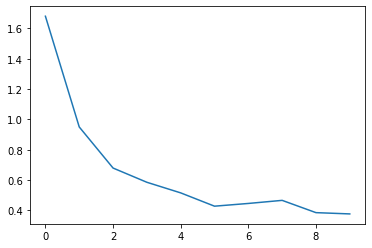

In [8]:
plt.plot(history.history['loss'])

In [9]:
model.save('model.h5')

In [10]:
model.evaluate(test_images)

38/38 [==============================] - 1s 27ms/step - loss: 0.5004 - categorical_accuracy: 0.8122


[0.5003986358642578, 0.8122414946556091]

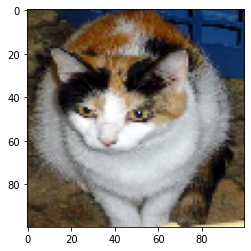

In [36]:
img = tf.keras.preprocessing.image.load_img("natural_images/cat/cat_0008.jpg", target_size=IMAGE_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)

plt.imshow(img)

In [37]:
predictions = model.predict(img_array)
scores = tf.nn.softmax(predictions[0])
#scores = predictions[0]

classes_reversed = {v: k for k, v in training_images.class_indices.items()}
guesses = {}

for i, score in enumerate(scores):
    class_name = classes_reversed[i]
    guesses[class_name] = score

for fruit, score in {k: v for k, v in sorted(guesses.items(), key=lambda item: item[1], reverse=True)}.items():
    pass
    print("{}: {:.2f}%".format(fruit, score * 100))


cat: 30.55%
dog: 11.82%
person: 11.53%
motorbike: 11.53%
car: 11.53%
airplane: 11.53%
fruit: 11.53%
